# Analysis of Multi-Periodized Training Regimen
Date: 2019-06-24  
Author: Jason Beach 
Categories: DataScience, Fitness  
Tags: R, tag2, tag3  
<!--eofm-->

Intro goes here.  Daily Strength app created by [Anthony Ng](https://github.com/nganthony).

## Config

We will be using python, with R for visualizations and other specific functions, as our main workflow.  We will also use the python-javascript autotranslation in order to convert JS integers into string-formatted dates.

In [1]:
# basics
import numpy as np
import pandas as pd
from pandas import Timestamp
#from sklearn import metrics
#from sklearn import linear_model
import pickle

np.__version__, pd.__version__

('1.15.4', '0.24.2')

In [2]:
%load_ext rpy2.ipython

df = pd.DataFrame({
    'cups_of_coffee': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
    'productivity': [2, 5, 6, 8, 9, 8, 0, 1, 0, -1]
})

In [3]:
%%R
options(warn=-1)   # do not show warnings: for presentation only

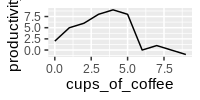

In [4]:
%%R -i df -w 2 -h 1 --units in -r 100 
library(ggplot2)
ggplot(df, aes(x=cups_of_coffee, y=productivity)) + geom_line()

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

In [6]:
pd.options.display.float_format = '{:20,.2f}'.format    # format decimal output 
pd.options.display.max_columns = None                   # show all columns in table
pd.options.mode.chained_assignment = None               # default='warn', turn-off this warning

## Data Preparation

In [7]:
! ls ./Data/DailyStrength

daily_strength_2019_06_23.zip  WorkoutExercise.json
daily-strength.csv	       WorkoutExerciseSet.json
data.csv		       Workout.json
reference		       WorkoutSessionExercise.json
Schedule.json		       WorkoutSession.json
tmp.json		       WorkoutSessionSet.json


In [8]:
import json

path = './Data/DailyStrength/'
file = 'WorkoutSession.json'
with open(path+file, 'r') as handle:
    parsed = json.load(handle)

In [9]:
with open(path+'tmp.json', 'w') as outfile:
    json.dump(parsed, outfile, indent=4, sort_keys=False)

In [10]:
! head ./Data/DailyStrength/tmp.json --lines 10

[
    {
        "workoutSessionExercises": [
            {
                "exercise": {
                    "category": "weight_and_reps",
                    "thumbnailUrl": "https://d3r2akiggou3b8.cloudfront.net/exercises/barbell_bench_press/180.gif",
                    "standardResolutionUrl": "https://d3r2akiggou3b8.cloudfront.net/exercises/barbell_bench_press/720.gif",
                    "equipment": "Barbell",
                    "id": "81266ff2-8ccb-4ba6-a3b2-37529dc58de5",


In [15]:
from pandas.io.json import json_normalize
tmp = json_normalize(parsed, record_path=['workoutSessionExercises','workoutSessionSets'], 
                     meta=['startDate','endDate',['workoutSessionExercises','exercise','name']], 
                     errors='ignore')

In [19]:
tmp.head(3)

,id,isComplete,measurementUnit,oneRepMax,reps,restTime,set,untilFailure,warmUp,weight,startDate,endDate,workoutSessionExercises.exercise.name
0,93a2d1b0-5289-4622-b691-aac0ab4ae7c5,True,lbs,291.19,3,60.00,1,False,False,275.00,1543692427000,1544406674446,Barbell Bench Press
1,089db444-c875-4bd5-9535-08b1ce9dd5c9,True,lbs,291.19,3,60.00,2,False,False,275.00,1543692427000,1544406674446,Barbell Bench Press
2,bd6d0c5a-1d20-404b-8276-16446029c0b6,True,lbs,282.86,2,60.00,3,False,False,275.00,1543692427000,1544406674446,Barbell Bench Press


In [23]:
from beakerx import beakerx
beakerx.Data = {"startDate": tmp.startDate.tolist() ,"endDate": tmp.endDate.tolist() }

In [42]:
%%javascript

var start = [];
var end = [];
for (var i = 0; i < beakerx.Data.startDate.length; i++) {
    var d1 = new Date( beakerx.Data.startDate[i] )
    start[i] = d1.toLocaleString()
    var d2 = new Date( beakerx.Data.endDate[i] )
    end[i] = d2.toLocaleString()
} 
beakerx.jsData = {start: start, end: end}

<IPython.core.display.Javascript object>

In [43]:
tmp['start'] = beakerx.jsData['start']
tmp['end'] = beakerx.jsData['end']
tmp1.to_csv(path+'data.csv', index=False)

Just kidding - that was all for fun!  The 'export to .csv' started working on the mobile app, so I was able to use it.

## Exploratory Data Analysis

In [69]:
path = './Data/DailyStrength/'
file = 'daily-strength.csv'
df = pd.read_csv(path+file)

df.Date = pd.to_datetime(df.Date, infer_datetime_format=True)
df['Day'] = df.Date.dt.date

df['Exercise'] = df['Exercise'].replace({'Cable Underhand Pulldown':'Pull Ups'})
df['Exercise'] = df['Exercise'].replace({'Barbell Squat To Bench':'Barbell Squat'})
df['Exercise'] = df['Exercise'].replace({'T-Bar Rows':'Bent Over Barbell Row'})

In [70]:
df.head()

,Date,Workout name,Exercise,Set,Weight,Reps,Distance,Duration,Measurement unit,Notes,Day
0,2018-12-01 14:27:07,Workout on the fly,Barbell Bench Press,1,275,3,nan,nan,lbs,nan,2018-12-01
1,2018-12-01 14:27:07,Workout on the fly,Barbell Bench Press,2,275,3,nan,nan,lbs,nan,2018-12-01
2,2018-12-01 14:27:07,Workout on the fly,Barbell Bench Press,3,275,2,nan,nan,lbs,nan,2018-12-01
3,2018-12-01 14:27:07,Workout on the fly,Barbell Bench Press,4,275,2,nan,nan,lbs,nan,2018-12-01
4,2018-12-01 14:27:07,Workout on the fly,Barbell Bench Press,5,275,2,nan,nan,lbs,nan,2018-12-01


In [68]:
(df.groupby('Exercise').count())['Date']

Exercise
Barbell Bench Press                145
Barbell Deadlifts                  163
Barbell Squat                       71
Bent Over Barbell Row               75
Clean                               13
Pull Ups                           148
Standing Barbell Military Press     68
Name: Date, dtype: int64

/opt/conda/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:61: UserWarning: Error while trying to convert the column "Day". Fall back to string conversion. The error is: Conversion 'py2ri' not defined for objects of type '<class 'datetime.date'>'
  (name, str(e)))


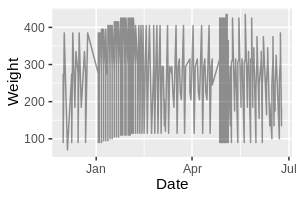

In [71]:
%%R -i df -w 3 -h 2 --units in -r 100 
df$Date <- as.Date(df$Date)

library(ggplot2)
ggplot(df, aes(x=Date, y=Weight)) + geom_line(alpha=0.4)

In [79]:
dfDay = df.groupby(['Day','Exercise'])['Weight'].mean()
dfDay = pd.DataFrame(dfDay)
tmp = df.groupby(['Day','Exercise']).count()
dfDay['Set'] = tmp.Set
dfDay.reset_index(inplace=True)
dfDay.head()

,Day,Exercise,Weight,Set
0,2018-12-01,Barbell Bench Press,275.00,5
1,2018-12-01,Pull Ups,90.00,5
2,2018-12-02,Barbell Deadlifts,385.00,5
3,2018-12-05,Standing Barbell Military Press,70.00,5
4,2018-12-09,Barbell Bench Press,275.00,5


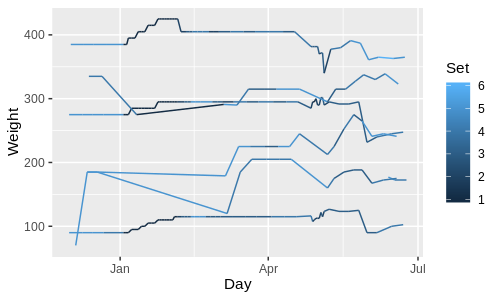

In [83]:
%%R -i dfDay -w 5 -h 3 --units in -r 100 
dfDay$Day <- as.Date(dfDay$Day, "%Y-%m-%d")

library(ggplot2)
ggplot(dfDay, aes(x=Day, y=Weight, group=Exercise)) + geom_line(aes(colour = Set))